# epitopepredict API basic usage

## Methodology

Predictors for each method inherit from the `Predictor` class and all implement a predict method for scoring a single sequence. This may wrap methods from other modules and/or call command line predictors. For example the `TepitopePredictor` uses the `mhcpredict.tepitope` module. This method should return a Pandas `DataFrame`. The `predictProteins` method is used for multiple proteins contained in a dataframe of sequences in a standard format. This is created from a genbank or fasta file (see examples below). For large numbers of sequences predictProteins you should provide a path so that the results are saved as each protein is completed to avoid memory issues, since many alleles might be called for each protein. Results are saved with one file per protein in csv format. Results can be loaded into the predictor individually or all together using the `load` method.

In [3]:
import os, math, time, pickle, subprocess
from importlib import reload
from collections import OrderedDict
import numpy as np
import pandas as pd
pd.set_option('display.width', 100)
import epitopepredict as ep
from epitopepredict import base, sequtils, tepitope, plotting, utilities, peptutils, mhclearn
from IPython.display import display, HTML, Image
%matplotlib inline
import matplotlib as mpl
import pylab as plt

In [4]:
#get preset alleles
m2_alleles = ep.get_preset_alleles('mhc2_supertypes')
m1_alleles = ep.get_preset_alleles('mhc1_supertypes')
print (m1_alleles)
print (m2_alleles)

['HLA-A*01:01', 'HLA-A*02:01', 'HLA-A*03:01', 'HLA-A*24:02', 'HLA-B*07:02', 'HLA-B*44:03']
['HLA-DRB1*01:01', 'HLA-DRB1*03:01', 'HLA-DRB1*04:01', 'HLA-DRB1*07:01', 'HLA-DRB1*08:01', 'HLA-DRB1*11:01', 'HLA-DRB1*13:01', 'HLA-DRB1*15:01']


In [5]:
data = mhclearn.get_training_set()
data.length.value_counts()
e = mhclearn.get_evaluation_set1()
print (e.length.value_counts())

9     25948
10     1376
8       763
11      488
15      154
12       71
14       15
13       13
26        3
16        2
30        1
24        1
Name: length, dtype: int64


## train models for basicmhc1 predictor before first use
this will be done automatically when you call the prediction methods if not run first

In [6]:
reload(mhclearn)
mhclearn.train_models(overwrite=True, alleles=['H-2-Kb'])#,'HLA-A*01:01','HLA-A*02:01','HLA-A*02:02','HLA-A*02:03','HLA-A*02:06'])

trained model: H-2-Kb 1611 9
trained model: H-2-Kb 374 10
trained model: H-2-Kb 140 11


In [7]:
a = mhclearn.get_allele_names()
print (len(a))

103


## predict random peptides

In [8]:
reload(base)
reload(mhclearn)
seqs = peptutils.create_random_sequences(1000)
print (seqs[:5])
df = pd.DataFrame(seqs,columns=['peptide'])
P = base.get_predictor('basicmhc1')

b = P.predict_peptides(df.peptide, alleles=m1_alleles, threads=8)

['QISLMKHMK', 'WLKTYNFMC', 'QARFEQSYP', 'VKKWMGSLS', 'MDAIFPEQN']


## results are returned as dataframes, sorted by score

In [9]:
print (b[:5])

     peptide  pos  log50k  score  name       allele  rank
0  RTEDAHMNY  132  0.7236  19.90  temp  HLA-A*01:01   1.0
1  MADDEIIDY  597  0.6797  31.99  temp  HLA-A*01:01   2.0
2  NTSKSEQVY   38  0.6093  68.53  temp  HLA-A*01:01   3.0
3  AVEYMHLQY  986  0.5991  76.53  temp  HLA-A*01:01   4.0
4  LMESQDAHY  176  0.5987  76.86  temp  HLA-A*01:01   5.0


## predict from a sequence

In [10]:
seq = 'MTDDPGSGFTTVWNAVVSELNGDPKVDDGP'
b = P.predict_sequences(seq, alleles=m1_alleles, length=9)
b

predictions done for 1 sequences in 6 alleles


,allele,log50k,name,peptide,pos,rank,score
0,HLA-A*01:01,0.3769,0,MTDDPGSGF,1,1.0,847.09
8,HLA-A*01:01,0.2390,0,FTTVWNAVV,9,2.0,3766.31
16,HLA-A*01:01,0.1480,0,VSELNGDPK,17,3.0,10081.44
1,HLA-A*01:01,0.1066,0,TDDPGSGFT,2,4.0,15778.29
12,HLA-A*01:01,0.1062,0,WNAVVSELN,13,5.0,15846.72
...,...,...,...,...,...,...,...
15,HLA-B*44:03,0.1032,0,VVSELNGDP,16,13.0,16369.53
16,HLA-B*44:03,0.1032,0,VSELNGDPK,17,13.0,16369.53
19,HLA-B*44:03,0.1032,0,LNGDPKVDD,20,13.0,16369.53
20,HLA-B*44:03,0.1032,0,NGDPKVDDG,21,13.0,16369.53


## predict n-mers from multiple protein sequence
This example loads protein sequences from mycobacterium tuberculosis from a genbank file

In [11]:
#load protein sequences into a dataframe
prots = ep.genbank_to_dataframe(base.mtb_genome, cds=True)
prots[:5]

,type,protein_id,locus_tag,gene,db_xref,product,note,translation,pseudo,pseudogene,start,end,strand,length,order
2,CDS,CCP42723.1,Rv0001,dnaA,GI:444893470,Chromosomal replication initiator protein DnaA,"Rv0001, (MT0001, MTV029.01, P49993), len: 507 ...",MTDDPGSGFTTVWNAVVSELNGDPKVDDGPSSDANLSAPLTPQQRA...,NaN,NaN,0,1524,1,507,1
4,CDS,CCP42724.1,Rv0002,dnaN,GI:444893471,DNA polymerase III (beta chain) DnaN (DNA nucl...,"Rv0002, (MTV029.02, MTCY10H4.0), len: 402 aa. ...",MDAATTRVGLTDLTFRLLRESFADAVSWVAKNLPARPAVPVLSGVL...,NaN,NaN,2051,3260,1,402,2
6,CDS,CCP42725.1,Rv0003,recF,GI:444893472,DNA replication and repair protein RecF (singl...,"Rv0003, (MTCY10H4.01), len: 385 aa. RecF, DNA ...",MYVRHLGLRDFRSWACVDLELHPGRTVFVGPNGYGKTNLIEALWYS...,NaN,NaN,3279,4437,1,385,3
8,CDS,CCP42726.1,Rv0004,NaN,GI:444893473,Conserved hypothetical protein,"Rv0004, (MTCY10H4.02), len: 187 aa. Conserved ...",MTGSVDRPDQNRGERSMKSPGLDLVRRTLDEARAAARARGQDAGRG...,NaN,NaN,4433,4997,1,187,4
10,CDS,CCP42727.1,Rv0005,gyrB,GI:444893474,DNA gyrase (subunit B) GyrB (DNA topoisomerase...,"Rv0005, (MTCY10H4.03), len: 675 aa. GyrB, DNA ...",MAAQKKKAQDEYGAASITILEGLEAVRKRPGMYIGSTGERGLHHLI...,NaN,NaN,5239,7267,1,675,5


In [12]:
proteins = ['Rv3615c','Rv3875','Rv1886c']
P1 = base.get_predictor('basicmhc1')
binders = P1.predict_sequences(prots, names=proteins, alleles=m1_alleles, length=9, threads=8)

predictions done for 3 sequences in 6 alleles


In [13]:
binders.head()

,allele,log50k,name,peptide,pos,rank,score
169,HLA-A*01:01,0.6958,Rv1886c,SSAMILAAY,170,1.0,26.88
93,HLA-A*01:01,0.6623,Rv1886c,NTPAFEWYY,94,2.0,38.62
114,HLA-A*01:01,0.6137,Rv1886c,QSSFYSDWY,115,3.0,65.34
118,HLA-A*01:01,0.5303,Rv1886c,YSDWYSPAC,119,4.0,161.10
222,HLA-A*01:01,0.3067,Rv1886c,SSDPAWERN,223,5.0,1810.49


## get promiscuous binders - those peptides above the cutoff for at least n alleles

In [ ]:
pb1 = P1.promiscuous_binders(n=2, cutoff=5, cutoff_method='rank')
pb1[:5]

## run other predictors

In [15]:
reload(base)
P2 = base.get_predictor('netmhcpan')
P2.predict_sequences(prots, names=proteins, alleles=m1_alleles, length=9, threads=8)

predictions done for 3 sequences in 6 alleles


,%Rank_BA,%Rank_EL,BindLevel,Gl,Gp,Icore,Identity,Il,Ip,Of,Score_BA,Score_EL,allele,core,ic50,name,peptide,pos,rank,score
114,0.064,0.248,<=,0,0,QSSFYSDWY,PEPLIST,0,0,0,0.608571,0.550058,HLA-A*01:01,QSSFYSDWY,69.07,Rv1886c,QSSFYSDWY,115,1.0,69.07
93,0.090,0.173,<=,0,0,NTPAFEWYY,PEPLIST,0,0,0,0.567313,0.661575,HLA-A*01:01,NTPAFEWYY,107.94,Rv1886c,NTPAFEWYY,94,2.0,107.94
169,0.095,0.201,<=,0,0,SSAMILAAY,PEPLIST,0,0,0,0.562260,0.624424,HLA-A*01:01,SSAMILAAY,114.01,Rv1886c,SSAMILAAY,170,3.0,114.01
118,0.624,1.533,<=,0,0,YSDWYSPAC,PEPLIST,0,0,0,0.321390,0.076134,HLA-A*01:01,YSDWYSPAC,1544.43,Rv1886c,YSDWYSPAC,119,4.0,1544.43
205,0.943,1.204,<=,0,0,LAMGDAGGY,PEPLIST,0,0,0,0.268694,0.111025,HLA-A*01:01,LAMGDAGGY,2731.40,Rv1886c,LAMGDAGGY,206,5.0,2731.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52,78.734,43.500,NaN,0,0,GVQQKWDAT,PEPLIST,0,0,0,0.015567,0.000028,HLA-B*44:03,GVQQKWDAT,42249.46,Rv3875,GVQQKWDAT,53,83.0,42249.46
46,88.447,80.000,NaN,0,0,GSEAYQGVQ,PEPLIST,0,0,0,0.012250,0.000003,HLA-B*44:03,GSEAYQGVQ,43793.29,Rv3875,GSEAYQGVQ,47,84.0,43793.29
28,90.081,37.333,NaN,0,0,LDEGKQSLT,PEPLIST,0,0,0,0.011645,0.000042,HLA-B*44:03,LDEGKQSLT,44080.89,Rv3875,LDEGKQSLT,29,85.0,44080.89
43,93.171,70.000,NaN,0,0,GGSGSEAYQ,PEPLIST,0,0,0,0.010310,0.000006,HLA-B*44:03,GGSGSEAYQ,44722.25,Rv3875,GGSGSEAYQ,44,86.0,44722.25


In [16]:
reload(base)
P3 = base.get_predictor('mhcflurry')
P3.predict_sequences(prots, names=proteins, alleles=m1_alleles, length=9, verbose=True)

name                      allele           top peptide        score
Rv1886c                   HLA-A*01:01      QSSFYSDWY          101.60968740437352 
Rv1886c                   HLA-A*02:01      LMIGTAAAV          16.43169597457016 
Rv1886c                   HLA-A*03:01      AMGDAGGYK          56.968563298042575 
Rv1886c                   HLA-A*24:02      IYAGSLSAL          41.91324793746497 
Rv1886c                   HLA-B*07:02      GPSLIGLAM          39.6257950091114 
Rv1886c                   HLA-B*44:03      WETFLTSEL          166.67921521067566 
Rv3615c                   HLA-A*01:01      QFNDTLNVY          804.3360154563782 
Rv3615c                   HLA-A*02:01      ALGSSLHTA          31.665793785308146 
Rv3615c                   HLA-A*03:01      HTAGVDLAK          87.12363499233405 
Rv3615c                   HLA-A*24:02      VYLTAHNAL          39.63350826881655 
Rv3615c                   HLA-B*07:02      LAKSLRIAA          329.70873449497435 
Rv3615c                   HLA-B*44:03

,allele,mhcflurry_affinity,mhcflurry_affinity_percentile,mhcflurry_presentation_percentile,mhcflurry_presentation_score,mhcflurry_processing_score,name,peptide,pos,rank,score
114,HLA-A*01:01,101.609687,0.139250,0.808750,0.505567,0.052885,Rv1886c,QSSFYSDWY,115,1.0,101.609687
93,HLA-A*01:01,175.248959,0.246500,0.685408,0.565139,0.270296,Rv1886c,NTPAFEWYY,94,2.0,175.248959
169,HLA-A*01:01,230.323815,0.310625,0.761630,0.527871,0.302801,Rv1886c,SSAMILAAY,170,3.0,230.323815
205,HLA-A*01:01,631.349649,0.644625,2.202255,0.152359,0.063034,Rv1886c,LAMGDAGGY,206,4.0,631.349649
92,HLA-A*01:01,990.540634,0.843250,2.778451,0.107109,0.072385,Rv1886c,INTPAFEWY,93,5.0,990.540634
...,...,...,...,...,...,...,...,...,...,...,...
18,HLA-B*44:03,32259.021322,40.329625,99.286603,0.003155,0.001343,Rv3875,QGNVTSIHS,19,83.0,32259.021322
52,HLA-B*44:03,32465.619160,46.498875,99.286603,0.003217,0.008599,Rv3875,GVQQKWDAT,53,84.0,32465.619160
35,HLA-B*44:03,32688.080557,46.498875,99.286603,0.003116,0.001443,Rv3875,LTKLAAAWG,36,85.0,32688.080557
37,HLA-B*44:03,32939.261826,53.881750,99.286603,0.003113,0.003266,Rv3875,KLAAAWGGS,38,86.0,32939.261826


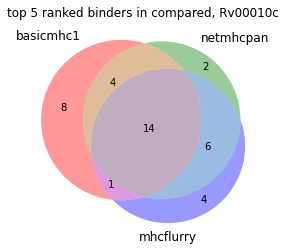

In [17]:
prot='Rv3615c'
b1 = P1.get_binders(cutoff=5,name=prot,cutoff_method='rank')
b2 = P2.get_binders(cutoff=5,name=prot,cutoff_method='rank')
b3 = P3.get_binders(cutoff=5,name=prot,cutoff_method='rank')
from matplotlib_venn import venn3
ax = venn3((set(b1.peptide),set(b2.peptide),set(b3.peptide)), set_labels = ('basicmhc1','netmhcpan','mhcflurry'))
plt.title('top 5 ranked binders in compared, Rv00010c')
plt.savefig('basicmhc1_binders_compared.jpg',dpi=150)

/home/damien/gitprojects/epitopepredict/epitopepredict/base.py:700: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binders['core'] = binders.peptide
/home/damien/gitprojects/epitopepredict/epitopepredict/base.py:700: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binders['core'] = binders.peptide


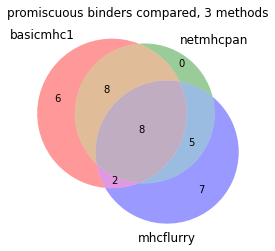

In [18]:
pb1 = P1.promiscuous_binders(n=2,cutoff=10,limit=10,cutoff_method='rank')
pb2 = P2.promiscuous_binders(n=2,cutoff=10,limit=10,cutoff_method='rank')
pb3 = P3.promiscuous_binders(n=2,cutoff=10,limit=10,cutoff_method='rank')
ax = venn3((set(pb1.peptide),set(pb2.peptide),set(pb3.peptide)), set_labels = ('basicmhc1','netmhcpan','mhcflurry'))
plt.title('promiscuous binders compared, 3 methods')
plt.savefig('basicmhc1_prom_binders_compared.jpg',dpi=150)

## plot binders in a protein sequence

['Rv1886c', 'Rv3615c', 'Rv3875']


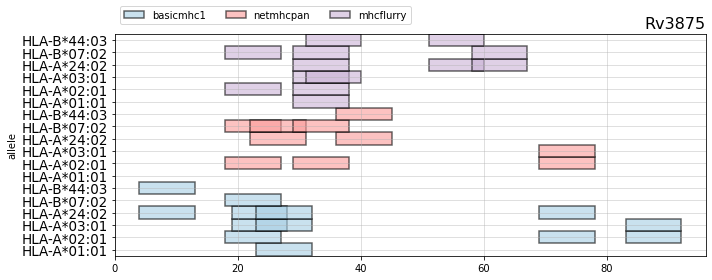

In [25]:
reload(plotting)
#get names of proteins stored in results of predictor
print (P2.get_names())
ax = plotting.plot_tracks([P1,P2,P3],name='Rv3875',cutoff=5,cutoff_method='rank',n=2,legend=True)
plt.tight_layout()
plt.savefig('comparison_rv3875.png',dpi=300)
#ax = plotting.plot_binder_map(P1,name='Rv0011c',cutoff=10)
#plt.savefig('mhc_rv0011c_map.png',dpi=150)

In [ ]:
reload(plotting)
from bokeh.io import show, output_notebook
output_notebook()
p = plotting.bokeh_plot_tracks([P1,P2,P3],name='Rv0008c',cutoff=10,cutoff_method='rank',n=2,width=800)
show(p)